# Определение возраста покупателей по фото

Техническое задание:

Компания внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.

Необходима модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

В работе использованы нейронные сети (библиотек Keras), наилучшие показатели дала Resnet. Также использованы библтиотеки PIL, pandas, numpy, matplotlib.

Импортируем модули, которые нам понадобятся для дальнейшей работы.

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Исследовательский анализ данных

Загружаем данные:

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Посмотрим на размер и характер базы:

In [ ]:
labels.shape

(7591, 2)

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
display(labels.sample(5).T)

,3775,2220,4804,291,6364
file_name,003775.jpg,002220.jpg,004804.jpg,000291.jpg,006368.jpg
real_age,2,11,22,51,36


В базе 7591 фотография лица человека и указание его реального возраста, причём в целых, скорее всего, округлённых в нижнюю сторону, как это принято при исчислении возраста (в полных годах). Посмотрим на распределение возраста в базе:

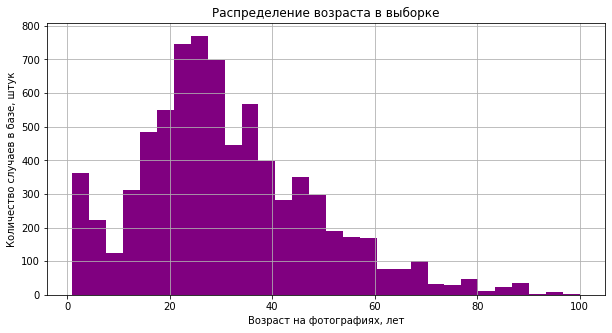

In [ ]:
labels['real_age'].hist(
    bins=30,
    color = 'Purple',
    figsize = (10,5))
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст на фотографиях, лет')
plt.ylabel('Количество случаев в базе, штук')
plt.show()

Удалять данные из выборки мы не будем, но внимание на высокое количество младенцев обратим. Необходимо уточнить у инженеров данной информационной базы, с чем связан такой пик в левой части графика. Или возраст всех детей в колясках или на руках у родителей определялся как 0 лет, или это ошибка занесения данных.

Посмотрим на сами фотографии.

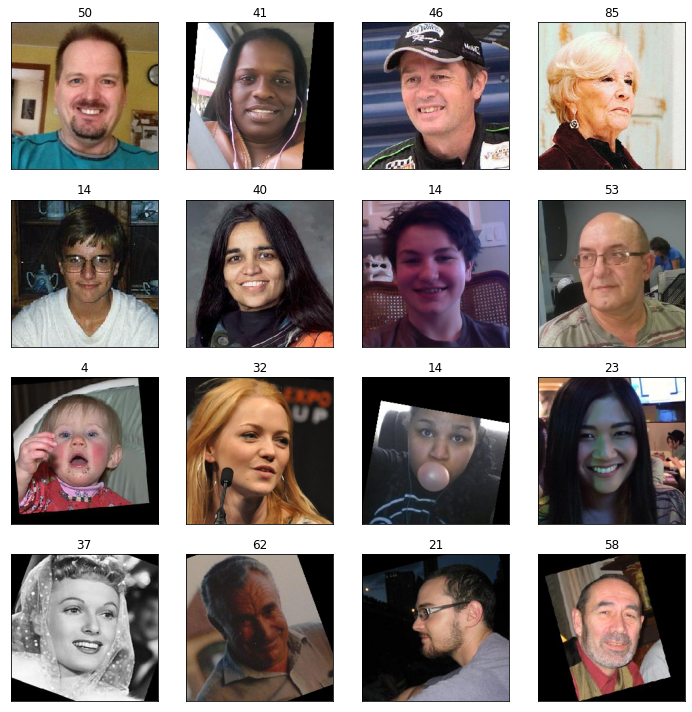

In [ ]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(target[i])
    plt.imshow(features[i])

На первый взгляд всё в порядке. Посмотрим на самых молодых из базы:

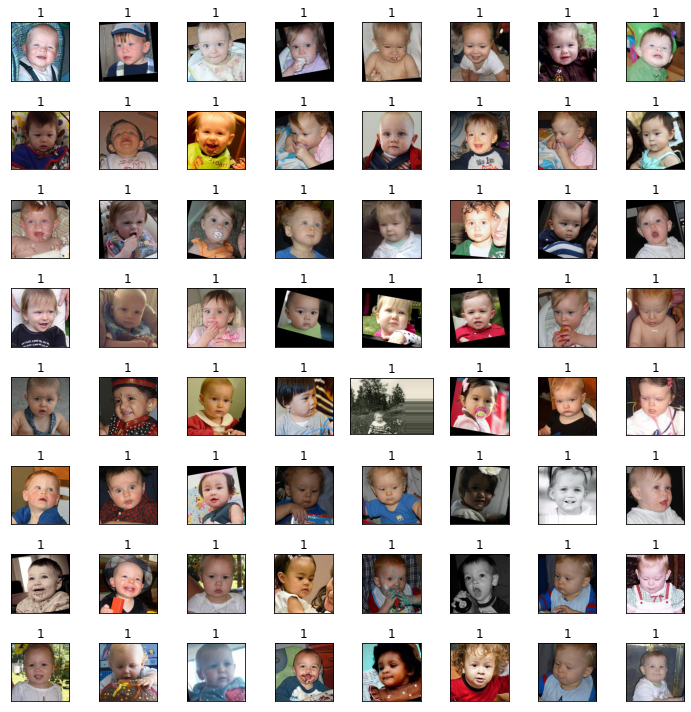

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(64):
    fig.add_subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(labels.sort_values(by='real_age', ignore_index=True).real_age[i])
    plt.imshow(
        np.array(
            Image.open(
                '/datasets/faces/final_files/%s' % (
                    labels.sort_values(by='real_age', ignore_index=True).file_name[i]))))

Похоже, что в базе действительно много младенцев, причём их возраст округляется по арифметическому принципу, а не по количеству полных лет (на фото большинству детей меньше 12 месяцев на вид).

### Вывод
В целом высокая доля детей не повлияет на способность будущей модели определять, какие товары предлагать покупателю и можно ли ему продавать алкоголь, однако стоит обсудить с поставщиком данных возможность удаления из базы детей младше возста совершения покупок в магазине "Хлеб-соль" (хотя бы до 12 лет).

## Обучение модели

Обучение модели проводилось в другой среде, поэтмоу скопируем код, который создаёт и обучает модель, в текстовую ячейку.

```python

from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

def load_train(path):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=7575)
    return train_datagen_flow
    
def load_test(path):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    val_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=7575)    
    return val_datagen_flow

def create_model(input_shape):
    backbone = ResNet152(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.0001), loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=0, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
```

```

Train for 356 steps, validate for 119 steps
Epoch 1/20
2022-04-03 09:57:57.610934: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-04-03 09:58:02.514343: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 169s - loss: 191.9129 - mae: 10.0751 - val_loss: 372.5225 - val_mae: 14.3943
Epoch 2/20
356/356 - 67s - loss: 72.1458 - mae: 6.5022 - val_loss: 195.1568 - val_mae: 10.5066
Epoch 3/20
356/356 - 67s - loss: 39.4419 - mae: 4.8138 - val_loss: 73.3668 - val_mae: 6.4703
Epoch 4/20
356/356 - 67s - loss: 23.5756 - mae: 3.7358 - val_loss: 67.5906 - val_mae: 6.1730
Epoch 5/20
356/356 - 67s - loss: 15.1419 - mae: 2.9839 - val_loss: 70.0529 - val_mae: 6.5039
Epoch 6/20
356/356 - 67s - loss: 12.0384 - mae: 2.6611 - val_loss: 77.1254 - val_mae: 6.9856
Epoch 7/20
356/356 - 67s - loss: 12.0473 - mae: 2.6337 - val_loss: 78.0264 - val_mae: 7.0323
Epoch 8/20
356/356 - 67s - loss: 10.1996 - mae: 2.4381 - val_loss: 71.2769 - val_mae: 6.3229
Epoch 9/20
356/356 - 67s - loss: 10.4151 - mae: 2.4055 - val_loss: 68.5307 - val_mae: 6.3770
Epoch 10/20
356/356 - 67s - loss: 10.1634 - mae: 2.3873 - val_loss: 64.3108 - val_mae: 6.1106
Epoch 11/20
356/356 - 67s - loss: 9.8174 - mae: 2.3887 - val_loss: 65.1401 - val_mae: 6.1096
Epoch 12/20
356/356 - 67s - loss: 9.7617 - mae: 2.3918 - val_loss: 71.7801 - val_mae: 6.4781
Epoch 13/20
356/356 - 67s - loss: 13.0818 - mae: 2.7294 - val_loss: 67.7655 - val_mae: 6.1844
Epoch 14/20
356/356 - 67s - loss: 14.3609 - mae: 2.8580 - val_loss: 68.7378 - val_mae: 6.0373
Epoch 15/20
356/356 - 67s - loss: 12.3335 - mae: 2.6320 - val_loss: 80.0012 - val_mae: 6.9130
Epoch 16/20
356/356 - 68s - loss: 8.6704 - mae: 2.2292 - val_loss: 66.1245 - val_mae: 5.9948
Epoch 17/20
356/356 - 68s - loss: 6.5615 - mae: 1.9191 - val_loss: 62.8721 - val_mae: 5.9863
Epoch 18/20
356/356 - 68s - loss: 4.8711 - mae: 1.6455 - val_loss: 61.9252 - val_mae: 5.9996
Epoch 19/20
356/356 - 68s - loss: 4.7073 - mae: 1.5889 - val_loss: 61.1737 - val_mae: 5.8359
Epoch 20/20
356/356 - 68s - loss: 4.6862 - mae: 1.6112 - val_loss: 66.5880 - val_mae: 6.0817
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 66.5880 - mae: 6.0817
Test MAE: 6.0817
```

```python
def load_train(path):
    datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.25)
```

## Анализ обученной модели

Мы сформировали модель (нейронную сеть), которая обучилась на популярном датасете лиц и сопоставленных им реальных возрастов людей. Теперь предположительно модель может определять возраст людей в очереди (если фотографии лиц будут сравнимы с качеством и прочими свойствами фотографий в датасете Faces) -+ 6 лет, что соответствует техническому заданию.

При формировании модели мы разделили выборку на тренировочную и валидационную. Используемый алгоритм - ResNet152. Чтобы избежать переобучения к модели добавлены верхние полносвязные слои. Ключевая метрика - MAE, поэтому она же и является критерием обучения сети, а функцией потерь - средне квардатическое отклонение. Параметр learning rate оптимизатора Adam подобран в ходе эксперименов.

При обучении модели количество эпох (20) также подобрано в ходе эксперименов так, чтобы минимизировать ключевую метрику, но не пожертвовать скоростью обучения.

Ошибка определения возраста в 6 лет может стать большой, если нужно, например, выявить долю пенсионеров среди всех покупателей супермаркета, чтобы рассчитать снижение маржи при предоставлении скидки данной категории покупателей. Однако поставленная задача связана с рекомендацией дополнительных товаров, а это соответствует скорее задаче категоризации, чем регрессии. То есть в конечном итоге будут рекомендованы группы товаров группам покупателей, одни и те же товары будут рекомендованы и 20-летним, и 26-летним покупателям, поэтому ошибку в 6 лет можно считать приемлемой для данной цели.